# Exercise 2

Train a LSTM to solve the same sequence classification problem using the given dataset

In [4]:
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

### Define Dataset

In [5]:
class PointSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        with open(data) as f:
            self.data = json.load(f)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = torch.tensor(self.data[idx]["sequence"])
        cls = torch.tensor(self.data[idx]["intersect"]).long()
        return seq, cls

Visualize an instance of the dataset

Training Samples: 8000
Each sample is made by 11 (x,y) datapoints and 1 label


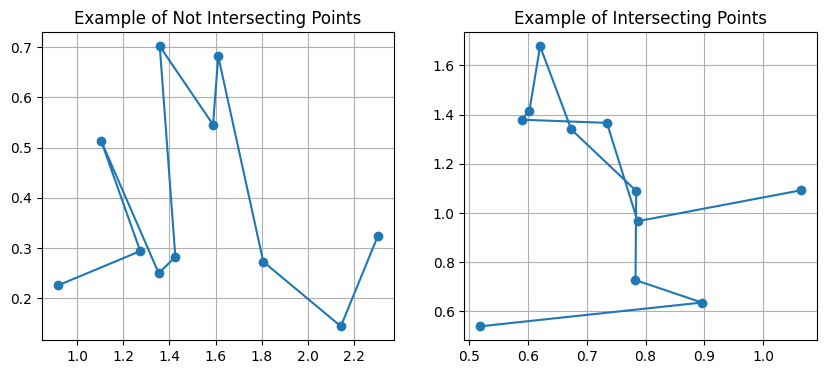

In [6]:
dataset = PointSequenceDataset("train_dataset.json")
print(f"Training Samples: {len(dataset)}")
print(f"Each sample is made by {len(dataset[0][0])} (x,y) datapoints and 1 label")

idx = [0, 6]
fig, axes = plt.subplots(1, len(idx), figsize=(10, 4))

for i1, i2 in enumerate(idx):
    datapoints, label = dataset[i2]
        
    x_coords = datapoints[:, 0]
    y_coords = datapoints[:, 1]
    
    # Plot the line
    axes[i1].plot(x_coords, y_coords, marker='o')  # 'o' for marking each point

    axes[i1].set_title('Example of Intersecting Points' if label else 'Example of Not Intersecting Points')
    axes[i1].grid(True)
plt.show()

### Define Model

In [7]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers=3, batch_first=True)
        self.ff = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.ff(out[:, -1, :])
        return out

In [8]:
train_ds = PointSequenceDataset("train_dataset.json")
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)

model = LSTMModel(2, 300, 2)
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

loss_history = []
acc_history = []

for epoch in range(20):
    bar = tqdm(enumerate(train_dl))
    for i, (serie, cls) in bar:
        serie = serie.to(DEVICE)
        cls = cls.to(DEVICE)
        
        out = model(serie)
        loss = loss_fn(out, cls)

        acc = (out.argmax(dim=1) == cls).float().mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bar.set_description(f"Epoch {epoch} Loss: {loss.item():.4f} Acc: {acc.item():.4f}")
        
        if i % 50 == 0:
            loss_history.append(loss.item())
            acc_history.append(acc.item())

Epoch 0 Loss 0.6890 Acc: 0.6562: : 250it [00:09, 26.27it/s]
Epoch 1 Loss 0.6922 Acc: 0.4688: : 250it [00:09, 26.90it/s]
Epoch 2 Loss 0.6958 Acc: 0.5625: : 250it [00:09, 26.56it/s]
Epoch 3 Loss 0.6764 Acc: 0.6250: : 250it [00:09, 26.33it/s]
Epoch 4 Loss 0.6539 Acc: 0.6250: : 250it [00:09, 27.37it/s]
Epoch 5 Loss 0.6448 Acc: 0.6875: : 250it [00:09, 27.16it/s]
Epoch 6 Loss 0.7330 Acc: 0.4375: : 250it [00:09, 26.94it/s]
Epoch 7 Loss 0.6968 Acc: 0.5938: : 250it [00:09, 27.25it/s]
Epoch 8 Loss 0.6731 Acc: 0.6250: : 250it [00:09, 27.34it/s]
Epoch 9 Loss 0.6152 Acc: 0.6875: : 250it [00:09, 27.15it/s]
Epoch 10 Loss 0.6216 Acc: 0.6562: : 250it [00:09, 26.91it/s]
Epoch 11 Loss 0.6033 Acc: 0.7188: : 250it [00:09, 27.19it/s]
Epoch 12 Loss 0.6301 Acc: 0.6250: : 250it [00:09, 27.39it/s]
Epoch 13 Loss 0.6609 Acc: 0.5938: : 250it [00:09, 27.32it/s]
Epoch 14 Loss 0.5793 Acc: 0.7500: : 250it [00:09, 27.31it/s]
Epoch 15 Loss 0.5322 Acc: 0.6875: : 250it [00:09, 27.18it/s]
Epoch 16 Loss 0.5880 Acc: 0.6875: 

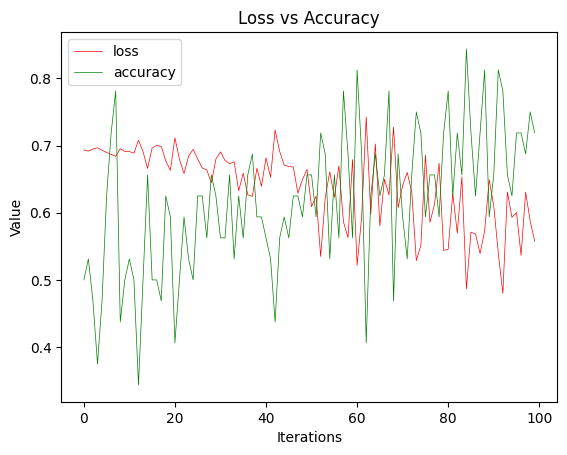

In [10]:
plt.plot(loss_history, color="red", label="loss", linewidth=0.5)
plt.plot(acc_history, color="green", label="accuracy", linewidth=0.5)

plt.xlabel("Iterations")
plt.ylabel("Value")

plt.title("Loss vs Accuracy")
plt.legend()
plt.show()